In [1]:
import nilearn
import nibabel as nib

import os
import pandas as pd
import numpy as np
import nibabel as nib
import glob
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiMapsMasker
from nilearn.image import concat_imgs, index_img, mean_img, math_img
from nilearn._utils import check_niimg
%matplotlib inline

/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 19

In [2]:
def get_fn(sub, ses, run=1, echo_n=None, combmode=None, denoised=False,
           root_dir='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep'):
    if not isinstance(sub, str):
        sub = str(sub).zfill(2)

    if ses == 'se':
        hdr = os.path.join(root_dir, 'sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz'.format(sub, sub, run))
        mask = os.path.join(root_dir, 'sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(sub, sub, run))
    elif ses == 'me':
        mask = os.path.join(root_dir, 'sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(sub, sub, run))
        if echo_n is None and combmode is not None:
            if denoised:
                hdr = './lcat_denoising/sub-{}_ses-me_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp-optcomb_bold_lcat-den.nii.gz'.format(sub, run)
            else:
                hdr = os.path.join(root_dir, 'sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp-{}_bold.nii.gz'.format(sub, sub, run, combmode))
        elif echo_n is not None and combmode is None:
            if denoised:
                hdr = './lcat_denoising/sub-{}_ses-me_task-stop_run-{}_echo-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold_lcat-den.nii.gz'.format(sub, echo_n, run)
            else:
                hdr = os.path.join(root_dir, 'sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz'.format(sub, sub, run, echo_n))

        else:
            raise(IOError('Requires either combmode or echo_n'))
    
    return hdr, mask

def make_tSNR_map(sub, ses, run=1, echo_n=None, combmode=None, denoised=False, save=True, overwrite=False):
    for run in [1,2,3]:
        hdr_fn, mask_fn = get_fn(sub, ses, run, echo_n, combmode, denoised=denoised)
        output_fn = hdr_fn.replace("_bold", "_tsnr")
        if os.path.exists(output_fn) and not overwrite:
            continue
        
        hdr = nib.load(hdr_fn)
        data = hdr.get_data()
        sig = np.mean(data, axis=3)
        noise = np.std(data, axis=3)
        tsnr = sig/noise
        
        tsnr[tsnr<0] = 0    # = np.clip(tsnr, a_min=0, a_max=250)
        tsnr[tsnr>250] = 0  # extremely high tsnrs occur due to the absence of signal: the temporal std is then (near) 0.
        
        mask = nib.load(mask_fn).get_data()
        sig[mask==0] = 0
        noise[mask==0] = 0
        tsnr[mask==0] = 0
        
        sig = nib.Nifti1Image(sig, affine=hdr.affine)
        noise = nib.Nifti1Image(noise, affine=hdr.affine)
        tsnr = nib.Nifti1Image(tsnr, affine=hdr.affine)
        
        output = concat_imgs([tsnr, sig, noise])
        nib.save(output, output_fn)
        print(output_fn)
    return 0

# Calculate voxel-wise tSNR
Create tSNR-maps first, then calculate the mean tSNR over voxels within a mask (weighted by probability)

In [3]:
import multiprocessing as mp
from functools import partial
import itertools
subs = [x for x in np.arange(1, 19) if not x == 12]
ses = ['se', 'optcomb', 1, 2, 3]
to_run = list(itertools.product(subs, ses))
# to_run

In [4]:
def mp_helper(to_run, overwrite=False):
    sub, ses = to_run
    
    if ses == 'se':
        make_tSNR_map(sub, ses, overwrite=overwrite)
    elif ses == 'optcomb':
        make_tSNR_map(sub, ses='me', combmode='optcomb', overwrite=overwrite)
    else:
        make_tSNR_map(sub, ses='me', echo_n=ses, overwrite=overwrite)
        
with mp.Pool(15) as p:
    p.map(partial(mp_helper, overwrite=False), to_run)

# Calculate voxel-wise theoretical CNR
(Gowland & Bowtell, 2007; Poser et al., 2006; Posse et al, 1999)

For single echo: 

$CNR = \frac{S\cdot TE}{\sigma}$

For multi echo:

$C = w \cdot S \cdot TE$

$\sigma = std(combined)$

In [5]:
def make_CNR_map(sub, ses, echo_n=None, combmode=None, denoised=False, save=True,
                 tes_me = [0.00966, 0.02487, 0.04008], te_se = 0.014, overwrite=False):
    for run in [1,2,3]:
        if (ses == 'se') or (ses == 'me' and echo_n is not None):
            hdr_fn, mask_fn = get_fn(sub, ses, run, echo_n, combmode, denoised=denoised)
            tsnr_fn = hdr_fn.replace('_bold', '_tsnr')
            out_fn = hdr_fn.replace('_bold', '_cnr')
            if os.path.exists(out_fn) and not overwrite:
                continue

            if echo_n is not None:
                te = tes_me[echo_n-1]
            else:
                te = te_se
            cnr = index_img(tsnr_fn, 0).get_data()*te
            cnr[cnr<0] = 0
            cnr = nib.Nifti1Image(cnr, affine=nib.load(hdr_fn).affine)
            # save
            nib.save(cnr, out_fn)
        elif ses == 'me' and combmode == 'optcomb':
            # get noise term
            hdr_fn, mask_fn = get_fn(sub, 'me', run=run, echo_n=None, combmode='optcomb')
            tsnr_fn = hdr_fn.replace('_bold', '_tsnr')
            out_fn = hdr_fn.replace('_bold', '_cnr')
            if os.path.exists(out_fn) and not overwrite:
                continue

            # get contrasts
            echos = [get_fn(sub, 'me', echo_n=x, run=run)[0] for x in [1,2,3]]
            echos_contrast = [mean_img(echos[x-1]).get_data()*tes_me[x-1] for x in [1,2,3]]

            # load t2s-map
            t2s = nib.load('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp-t2svG_bold.nii.gz'.format(str(sub).zfill(2), str(sub).zfill(2), run))
            t2s_dat = t2s.get_data()

            # get weights (optcomb method)
            weights = [tes_me[x-1]*np.exp(-tes_me[x-1]/t2s_dat) for x in [1,2,3]]
            weights_normalized = weights/np.sum(np.array(weights), axis=0)

            # weight each individual contrast
            echos_weighted = [echos_contrast[x]*weights_normalized[x,:,:,:] for x in [0,1,2]]        
            contrast = np.sum(np.array(echos_weighted), axis=0)

            noise = index_img(nib.load(tsnr_fn), 2)
            cnr = nib.Nifti1Image(contrast / noise.get_data(), affine=t2s.affine)
            nib.save(cnr, out_fn)
            # save
    return 0

In [6]:
def mp_helper(to_run, **kwargs):
    sub, ses = to_run
#     print('{} {}'.format(sub, ses))
    if ses == 'se':
        make_CNR_map(sub, ses, **kwargs)
    elif ses == 'optcomb':
        make_CNR_map(sub, ses='me', combmode='optcomb', **kwargs)
    else:
        make_CNR_map(sub, ses='me', echo_n=ses, **kwargs)
        
with mp.Pool(15) as p:
    p.map(partial(mp_helper, overwrite=False), to_run)

## Utility functions for further analysis

In [7]:
from utils import *
atlas = load_atlas()

def get_fn_short(sub, ses=None, run=1, output_type='tsnr'):
    if ses == 'se':
        bold = get_fn(sub, 'se', run=run)[0]
    elif ses == 'optcomb':
        bold = get_fn(sub, ses='me', combmode=ses, run=run)[0]
    else:
        bold = get_fn(sub, ses='me', echo_n=ses[-1], run=run)[0]
    
    if output_type == 'tsnr':
        return bold.replace('_bold', '_tsnr')
    elif output_type == 'cnr':
        return bold.replace('_bold', '_cnr')

def get_roi_values(nii, atlas):
    data = nii.get_data()
    
    # identify voxels that shouldn't be weighted: cnr/tsnr can't be <0, >1000, or nan.
    # these can arise, mostly at the edges of the brain, due to numerical issues (T2* estimation, division by small noise, etc)
    bad_voxel_idx = (data < 0) | (data > 1000) | np.isnan(data)
    # set to 0 in data
    data[bad_voxel_idx] = 0
    
    out = pd.Series(index=pd.Index(atlas.labels))
    for mask_id in np.arange(atlas.maps.shape[-1]):
        # get in mask
        mask_label = [x for x in atlas.labels][mask_id]
        this_mask = index_img(atlas.maps, mask_id).get_data()
        this_mask[bad_voxel_idx] = 0  # bad values, don't weigh these
        
        val_weighted = np.average(data, weights=this_mask)  # inf * 0 = np.nan -> manually set np.nans to 0
        out[mask_label] = val_weighted
    return out

def _make_fn_df(output_type='tsnr'):
    subs = [str(x).zfill(2) for x in np.arange(1, 19) if not x == 12]
    runs = [1,2,3]
    data_types = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']
    index = pd.MultiIndex.from_product([subs, data_types, runs], names=['subject', 'data_type', 'run'])
    fn_df = pd.DataFrame(index=index, columns=['fn'])
    fn_df['fn'] = fn_df.reset_index().apply(lambda x: get_fn_short(x['subject'], x['data_type'], x['run'], output_type=output_type), axis=1).values
    
    # check if all niis exist, load only those that exist
    fn_df['exists'] = fn_df['fn'].apply(os.path.exists)
    fn_df = fn_df[fn_df['exists']]
    if output_type == 'tsnr':
        fn_df['nii'] = fn_df['fn'].apply(lambda x: index_img(x, 0)) # don't forget to index: first is the tSNR
    else:
        fn_df['nii'] = fn_df['fn'].apply(nib.load)
    return fn_df

def get_subjectwise_rois(output_type='tsnr', atlas=atlas):
    fn_df = _make_fn_df(output_type=output_type)
    # get mean across runs
    means_across_runs = fn_df.groupby(['data_type', 'subject']).apply(lambda x: mean_img(x['nii']))
    roiwise_df = means_across_runs.apply(get_roi_values, atlas=atlas)
    return roiwise_df

def get_wholebrain_niis(output_type='tsnr'):
    fn_df = _make_fn_df(output_type=output_type)
    
    # get mean across runs
    means_across_runs = fn_df.groupby(['data_type', 'subject']).apply(lambda x: mean_img(x['nii']))
    
    # and across subs
    means_across_subs = means_across_runs.reset_index().groupby('data_type').apply(lambda x: mean_img(x[0]))    
    
    return means_across_subs

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


## tSNR analysis

In [8]:
# get dataframe with subject-wise roi-wise tSNR
subjectwise_tsnrs = get_subjectwise_rois('tsnr')

In [9]:
index_order = ['Single echo', 'Multi echo combined', 'Echo 1', 'Echo 2', 'Echo 3']
column_order = ['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'rSTN']

In [10]:
# get means
roiwise_tsnr = subjectwise_tsnrs.groupby(level=[0]).mean()[column_order]
roiwise_tsnr = roiwise_tsnr.rename(index={'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3', 'optcomb': 'Multi echo combined', 'se': 'Single echo'})
roiwise_tsnr.index.name = 'Data type'
roiwise_tsnr = roiwise_tsnr.reindex(index = index_order)

In [11]:
# get standard deviations
roiwise_tsnr_std = subjectwise_tsnrs.groupby(level=[0]).std()[column_order]
roiwise_tsnr_std = roiwise_tsnr_std.rename(index={'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3', 'optcomb': 'Multi echo combined', 'se': 'Single echo'})
roiwise_tsnr_std.index.name = 'Data type'
roiwise_tsnr_std = roiwise_tsnr_std.reindex(index = index_order)

In [12]:
tsnr_table = pd.DataFrame(columns=roiwise_tsnr.columns, index=roiwise_tsnr.index)
for row in range(roiwise_tsnr.shape[0]):
    for col in range(roiwise_tsnr.shape[1]):
        tsnr_table.iloc[row, col] = '{:.2f} ({:.2f})'.format(roiwise_tsnr.iloc[row, col],
                                                             roiwise_tsnr_std.iloc[row, col])
tsnr_table.to_csv('figures/cnr_table.csv', sep='\t')
tsnr_table

,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN
Data type,,,,,,,
Single echo,89.69 (15.32),86.48 (13.45),81.30 (15.46),71.94 (10.90),55.26 (9.63),58.40 (8.89),59.70 (8.22)
Multi echo combined,60.23 (8.66),60.25 (7.69),58.03 (9.13),43.47 (4.27),31.54 (3.68),32.53 (4.19),34.58 (3.47)
Echo 1,71.68 (7.33),66.88 (6.62),65.70 (7.81),44.78 (4.00),32.03 (3.84),32.36 (4.34),34.55 (4.12)
Echo 2,40.43 (4.27),42.07 (4.52),39.46 (5.60),23.10 (2.79),10.89 (1.56),12.46 (1.90),14.30 (1.62)
Echo 3,24.86 (2.90),27.52 (3.63),24.03 (3.87),12.27 (1.85),5.55 (0.60),6.47 (0.80),6.16 (0.73)


In [13]:
# get cell background colors
from matplotlib.colorbar import ColorbarBase
from matplotlib import colors
import matplotlib

cmap = plotting.cm.cold_hot
def norm(x, x_max=150, vmax=256, vmin=0):
    return int(vmax/2 + (x/x_max)*(vmax-vmin)/2)

def get_hex(tsnr, cmap, **kwargs):
    rgb = cmap(norm(tsnr, **kwargs))[:3]   # no alpha
    return matplotlib.colors.rgb2hex(rgb)

# make RGB table
color_table_rgb = np.empty((roiwise_tsnr.shape[0], roiwise_tsnr.shape[1], 3))
color_table_hex = roiwise_tsnr.copy()
for row in range(roiwise_tsnr.shape[0]):
    for col in range(roiwise_tsnr.shape[1]):
        x = get_hex(roiwise_tsnr.iloc[row, col], cmap=cmap)
        color_table_hex.iloc[row, col] = x
        color_table_rgb[row, col, :] = cmap(norm(roiwise_tsnr.iloc[row, col]))[:3]

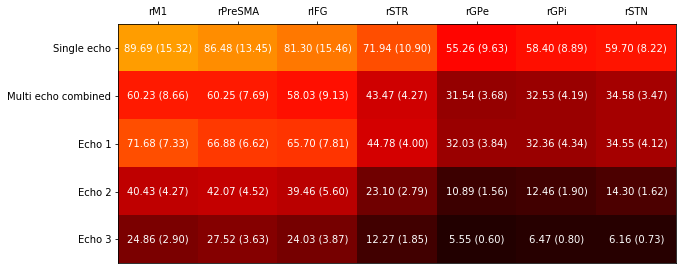

In [14]:
# combine in plot of table
fig, ax = plt.subplots()
ax.imshow(color_table_rgb, aspect=0.6)

for i in range(len(roiwise_tsnr)):
    for j in range(len(roiwise_tsnr.columns)):
        ax.text(j, i, '{:.2f} ({:.2f})'.format(roiwise_tsnr.values[i, j], roiwise_tsnr_std.values[i,j]), 
                ha="center", va="center", color='white')

ax.set_xticklabels(np.hstack(['', roiwise_tsnr.columns]))
ax.set_yticklabels(np.hstack(['', roiwise_tsnr.index.values]))
ax.xaxis.tick_top()
fig.set_size_inches(10,10)
fig.savefig('figures/tsnr_table.pdf', bbox_inches='tight')

In [15]:
# whole brain
wholebrain_tsnr = get_wholebrain_niis()

In [16]:
stat_maps_tsnr = wholebrain_tsnr[['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']].values
len(stat_maps_tsnr)

5

In [17]:
templt = nib.load('template/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii')
black_bg = templt.get_data()
black_bg[black_bg>0] = 0
black_bg = nib.Nifti1Image(black_bg, affine=templt.affine)

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were fo

Text(0.5, 1.0, 'tSNR')

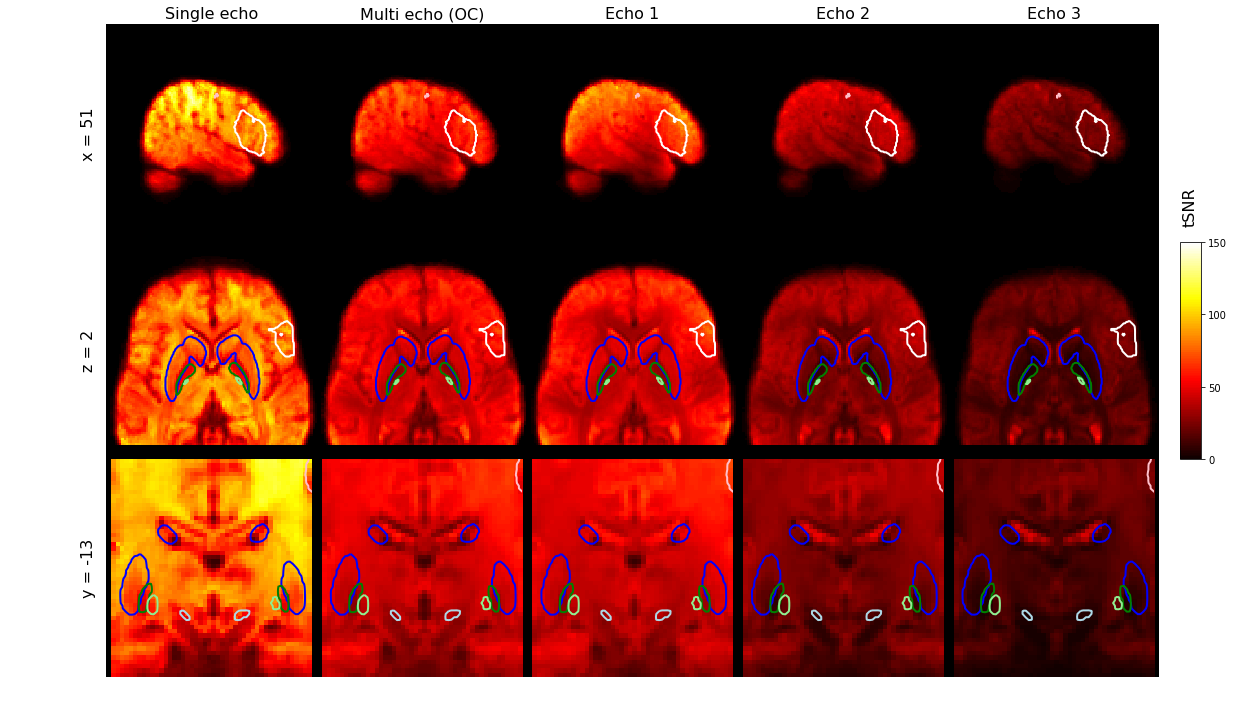

In [18]:
# plot
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 1, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(stat_maps_tsnr)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(stat_maps_tsnr)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(stat_maps_tsnr, roi_dict=get_roi_dict(), z_threshold=0,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=black_bg,
                          vmax=150, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Single echo', size=16)
axes[0,1].set_title('Multi echo (OC)', size=16)
axes[0,2].set_title('Echo 1', size=16)
axes[0,3].set_title('Echo 2', size=16)
axes[0,4].set_title('Echo 3', size=16)

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Positions
axes[0,0].set_ylabel('x = 51', labelpad=24, size=16)
axes[1,0].set_ylabel('y = 2', labelpad=24, size=16)
axes[2,0].set_ylabel('z = -13', labelpad=24, size=16)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=150, truncation_limits=(0,150), offset=0, flip=False)
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('tSNR', rotation=90, fontsize=16, ha='center', va='bottom', pad=16)

In [19]:
f.savefig('figures/tsnr_wholebrain.pdf', bbox_inches='tight')

### CNR analysis

In [20]:
subjectwise_cnrs = get_subjectwise_rois('cnr')

In [21]:
roiwise_cnr = subjectwise_cnrs.groupby(level=[0]).mean()[column_order]
roiwise_cnr = roiwise_cnr.rename(index={'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3', 'optcomb': 'Multi echo combined', 'se': 'Single echo'})
roiwise_cnr.index.name = 'Data type'
roiwise_cnr = roiwise_cnr.reindex(index = index_order)

In [22]:
roiwise_cnr_std = subjectwise_cnrs.groupby(level=[0]).std()[column_order]
roiwise_cnr_std = roiwise_cnr_std.rename(index={'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3', 'optcomb': 'Multi echo combined', 'se': 'Single echo'})
roiwise_cnr_std.index.name = 'Data type'
roiwise_cnr_std = roiwise_cnr_std.reindex(index = index_order)

In [23]:
cnr_table = pd.DataFrame(columns=roiwise_cnr.columns, index=roiwise_cnr.index)
for row in range(roiwise_cnr.shape[0]):
    for col in range(roiwise_cnr.shape[1]):
        cnr_table.iloc[row, col] = '{:.2f} ({:.2f})'.format(roiwise_cnr.iloc[row, col],
                                                           roiwise_cnr_std.iloc[row, col])
cnr_table.to_csv('figures/cnr_table.csv', sep='\t')
cnr_table

,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN
Data type,,,,,,,
Single echo,1.30 (0.22),1.22 (0.19),1.15 (0.22),1.01 (0.15),0.77 (0.13),0.82 (0.12),0.84 (0.12)
Multi echo combined,1.33 (0.18),1.40 (0.18),1.28 (0.20),0.81 (0.09),0.46 (0.05),0.51 (0.07),0.53 (0.05)
Echo 1,0.69 (0.07),0.65 (0.06),0.63 (0.08),0.43 (0.04),0.31 (0.04),0.31 (0.04),0.33 (0.04)
Echo 2,1.01 (0.11),1.05 (0.11),0.98 (0.14),0.57 (0.07),0.27 (0.04),0.31 (0.05),0.36 (0.04)
Echo 3,1.00 (0.12),1.10 (0.15),0.96 (0.16),0.49 (0.07),0.22 (0.02),0.26 (0.03),0.25 (0.03)


In [24]:
# get cell background colors
from matplotlib.colorbar import ColorbarBase
from matplotlib import colors
import matplotlib

# make RGB table
color_table_rgb = np.empty((roiwise_cnr.shape[0], roiwise_cnr.shape[1], 3))
color_table_hex = roiwise_cnr.copy()
for row in range(roiwise_cnr.shape[0]):
    for col in range(roiwise_cnr.shape[1]):
        x = get_hex(roiwise_cnr.iloc[row, col], cmap=cmap, x_max=2)
        color_table_hex.iloc[row, col] = x
        color_table_rgb[row, col, :] = cmap(norm(roiwise_cnr.iloc[row, col], x_max=2))[:3]

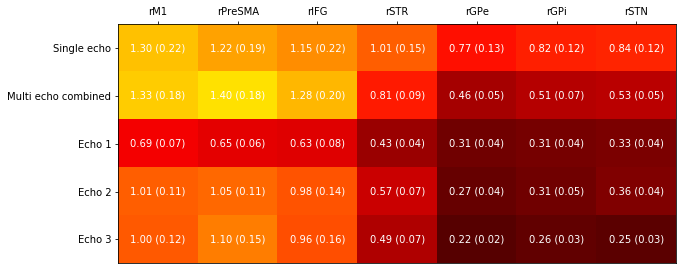

In [25]:
# combine in plot of table
fig, ax = plt.subplots()
ax.imshow(color_table_rgb, aspect=0.6)

for i in range(len(roiwise_cnr)):
    for j in range(len(roiwise_cnr.columns)):
        ax.text(j, i, '{:.2f} ({:.2f})'.format(roiwise_cnr.values[i, j], roiwise_cnr_std.values[i,j]), 
                ha="center", va="center", color='white')

ax.set_xticklabels(np.hstack(['', roiwise_cnr.columns]))
ax.set_yticklabels(np.hstack(['', roiwise_cnr.index.values]))
ax.xaxis.tick_top()
fig.set_size_inches(10,10)
fig.savefig('figures/cnr_table.pdf', bbox_inches='tight')

In [26]:
wholebrain_cnr = get_wholebrain_niis('cnr')
stat_maps_cnr = wholebrain_cnr[['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']].values

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotli

Text(0.5, 1.0, 'CNR')

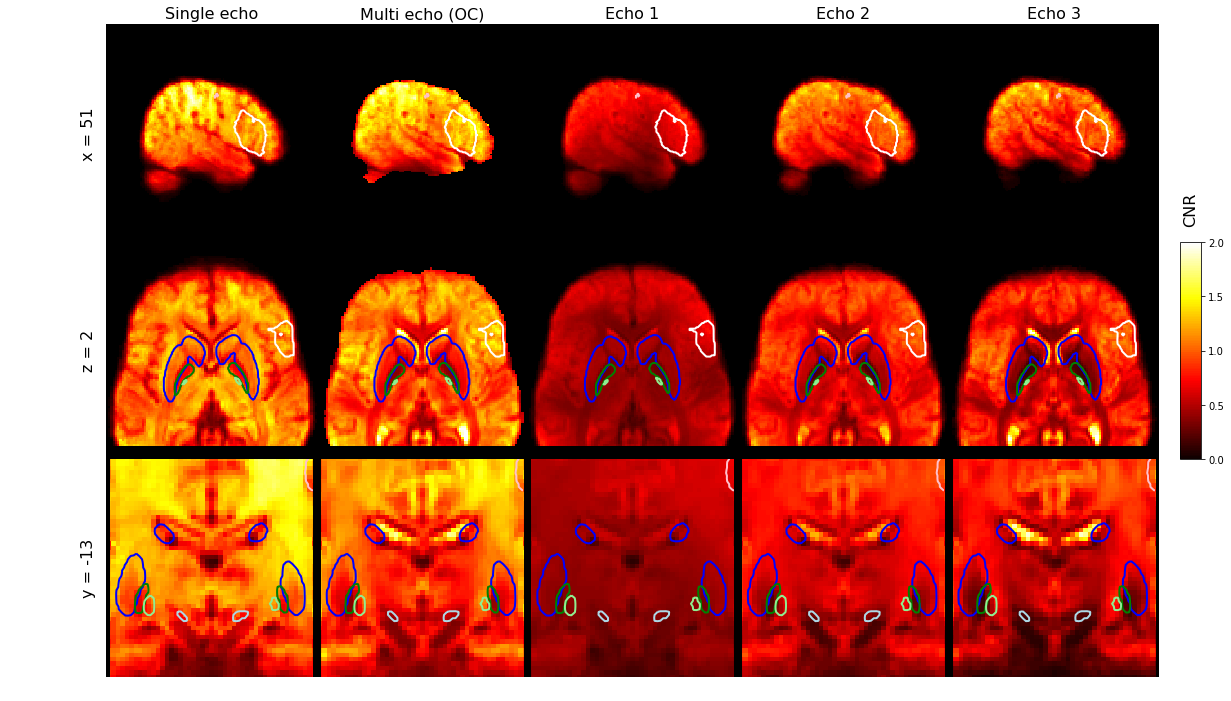

In [27]:
# plot
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 1, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(stat_maps_cnr)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(stat_maps_cnr)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(stat_maps_cnr, roi_dict=get_roi_dict(), 
                          z_threshold=0.01,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=black_bg,
                          vmax=2, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Single echo', size=16)
axes[0,1].set_title('Multi echo (OC)', size=16)
axes[0,2].set_title('Echo 1', size=16)
axes[0,3].set_title('Echo 2', size=16)
axes[0,4].set_title('Echo 3', size=16)

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Positions
axes[0,0].set_ylabel('x = 51', labelpad=24, size=16)
axes[1,0].set_ylabel('z = 2', labelpad=24, size=16)
axes[2,0].set_ylabel('y = -13', labelpad=24, size=16)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=2, truncation_limits=(0,2), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('CNR', rotation=90, fontsize=16, ha='center', va='bottom', pad=16)

In [28]:
f.savefig('figures/cnr_wholebrain.pdf', bbox_inches='tight')